create sudo lables with known cell types number

In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd

In [2]:
dir_path = "/home/krushna/Documents/Data_integration/SCRNA_Datasets/All_h5ad/"
emb_dir =  "/home/krushna/Documents/Data_integration/Othermethods/ourmethod/self-sup/pipeline_tf2 50/step1/"
batch_key_dic = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 
                }
cell_type_key_dic = {'Immune_Human' : 'final_annotation',
                 'Lung' : 'cell_type',
                 'Pancreas' : 'celltype',
                 'Human_Mouse' : "celltype",
                 "Human_Retina":"Subcluster",
                    }    

#got these results from GMM
req_clus_dic = {"Lung" : 17,
                        "Pancreas": 14,
                        "Immune_Human": 16,
                "Human_Retina" : 13
                       }

def load_data(dataset,batch_key):
    adata =sc.read_h5ad(dir_path+dataset+'.h5ad')
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    sc.pp.highly_variable_genes(
            adata,
            flavor="seurat",
            n_top_genes=2000,
            layer="counts",
            batch_key=batch_key,
            subset=True
    )
    # adata_sep=[]
    # for batch in np.unique(adata.obs[batch_key]):
    #     sep_batch=adata[adata.obs[batch_key]==batch]
    #     sc.pp.scale(sep_batch,max_value=10)
    #     adata_sep.append(sep_batch)
    # adata=sc.AnnData.concatenate(*adata_sep)
    return adata

In [3]:
dataset = 'Lung'

cell_type = cell_type_key_dic[dataset]
batch = batch_key_dic[dataset]
req_clusters = req_clus_dic[dataset]

adata = sc.read_h5ad(dir_path+dataset+'.h5ad')
emb=pd.read_csv(emb_dir+dataset+"_latent_matrix_c99_step1.csv",header=None)
adata.obsm['X_emb']=emb.values
no_of_cell_types = len(adata.obs[cell_type].unique())
sc.pp.neighbors(adata,use_rep='X_emb')
sc.tl.umap(adata)

In [4]:
emb=pd.read_csv(emb_dir+dataset+"_latent_matrix_c99_step1.csv",header=None)
emb=sc.AnnData(emb)
sc.pp.neighbors(emb,use_rep='X',random_state=0)

<ipython-input-4-d00496c0602f>:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  emb=sc.AnnData(emb)
/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
def find_resolution(adata_org, n_clusters):
    adata = adata_org.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = 0)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        iteration = iteration + 1
    print("find resolution iterations = {}, obtained_clusters = {}".format(iteration,obtained_clusters))
    return current_res

In [6]:
# Pancreas 0.732421875
# Lung 0.8544921875
opt_res = find_resolution(emb, req_clusters) #no_of_cell_types
opt_res  #=  0.8544921875

find resolution iterations = 13, obtained_clusters = 17


0.8544921875

In [7]:
sc.tl.louvain(emb, resolution = opt_res, key_added='pseudo_cell_types')

In [8]:
# clusters = np.array([[0,1],[1,0],[0,0],[1,1]])
# from_points = np.array([[10,10],[1,1]])
def farthest_point(clusters, from_points):
    distances = np.zeros(clusters.shape[0])
    for point_ind,point in enumerate(clusters):
        dist = from_points.copy()
        dist = ((dist-point)**2).sum()
        distances[point_ind] = dist
    far_ind = distances.argmax()
    far_point = clusters[far_ind]
    return far_point

In [9]:
from annoy import AnnoyIndex

def nn_annoy(mean, emb, no_of_nn):
    tree = AnnoyIndex(emb.shape[1], metric="angular") #euclidean
    tree.set_seed(0)
    for i in range(emb.shape[0]):
        tree.add_item(i, emb[i, :])
    tree.build(50)
    ind = tree.get_nns_by_vector(mean, no_of_nn, search_k=-1) #search_k=-1 means extract search neighbors
    return ind

def update_sudo_lables(adata,label_percent):
    adata.obs['celltype_NA'] = adata.obs['pseudo_cell_types'].cat.add_categories(['NA'])
    from_points = np.zeros((len(adata.obs['pseudo_cell_types'].unique()),adata.X.shape[1]))
    from_points_ind = 0
    for label in adata.obs['pseudo_cell_types'].unique():
        if label == 'NA':
            continue
        is_label = adata.obs['pseudo_cell_types'] == label
        names = adata.obs['pseudo_cell_types'][is_label].index
        data = adata[is_label].X 
        mean = data.mean(axis=0)
        from_points[from_points_ind] = mean
        from_points_ind +=1 
        
    for label in adata.obs['pseudo_cell_types'].unique():
        is_label = adata.obs['pseudo_cell_types'] == label
        no_of_nn = int(sum(is_label)*label_percent) #noofnearestnighbors
        names = adata.obs['pseudo_cell_types'][is_label].index
        data = adata[is_label].X 
        # mean = data.mean(axis=0)
        mean = farthest_point(data, from_points)
        ind = nn_annoy(mean,data,no_of_nn)
        adata.obs['celltype_NA'][names] = 'NA'
        adata.obs['celltype_NA'][names[ind]] = label
        

In [10]:
update_sudo_lables(emb, label_percent = 0.3)

In [11]:
#confirming NA percentage
print('na percentage : ', sum(emb.obs['celltype_NA']=='NA')/emb.shape[0]*100)

na percentage :  70.02648435575264


In [12]:
adata.obs["pseudo_cell_types"]=emb.obs["pseudo_cell_types"].values.copy()
adata.obs["celltype_NA"]=emb.obs["celltype_NA"].values.copy()

In [13]:
purity = pd.DataFrame(columns = sorted(adata.obs[cell_type].unique()))
for cluster in  adata.obs["celltype_NA"].unique(): #['5','6','8']:
    temp = pd.DataFrame(adata.obs[cell_type][adata.obs["celltype_NA"]== cluster].value_counts()).T
    temp.index = [cluster]
    purity = pd.concat([purity,temp], axis = 0)
purity['variance'] = 0
for cluster in  adata.obs["pseudo_cell_types"].unique():
    var = np.var(adata[adata.obs["pseudo_cell_types"]== cluster].obsm['X_emb'], axis = 0).sum()
    purity.loc[cluster,'variance'] = var
purity.sort_index()


,B cell,Basal 1,Basal 2,Ciliated,Dendritic cell,Endothelium,Fibroblast,Ionocytes,Lymphatic,Macrophage,Mast cell,Neutrophil_CD14_high,Neutrophils_IL1R2,Secretory,T/NK cell,Type 1,Type 2,variance
0,29,0,0,0,4,0,0,0,0,1306,0,2,0,0,0,0,1,5.200380
1,49,0,0,0,748,0,0,0,0,331,1,46,81,1,6,0,2,10.718550
10,0,0,0,0,0,303,0,0,0,0,0,0,0,0,0,0,0,10.009902
11,0,0,0,0,0,0,0,0,0,0,255,0,0,0,0,0,0,5.636641
12,0,0,0,0,0,0,217,0,0,0,0,0,0,0,0,0,0,7.593140
13,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,161,4,6.059652
14,0,0,0,60,0,0,0,0,0,0,0,0,0,90,0,0,0,4.192301
15,0,0,0,0,0,0,0,0,102,0,0,0,0,0,0,0,0,5.158535
16,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,2.022015
2,5,0,0,0,0,0,0,0,0,1,0,0,0,12,1,0,1212,4.137636


/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


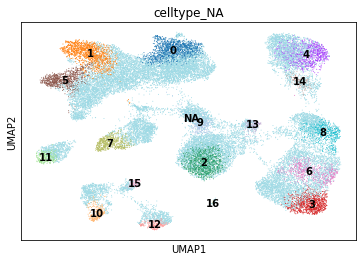

/home/krushna/Softwares/Anaconda3/envs/tf2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


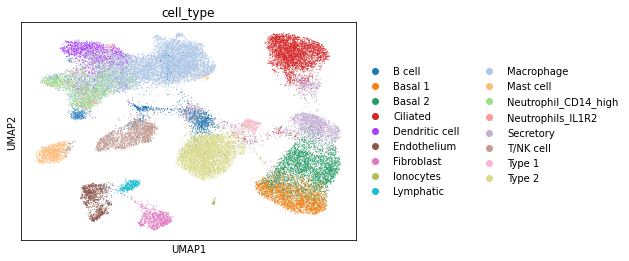

In [14]:
sc.pl.umap(adata,color=['celltype_NA'], legend_loc='on data')
sc.pl.umap(adata,color=[cell_type])

In [ ]:
# sc.tl.louvain(adata, resolution = 1.5, key_added = 'louvain_1.5')
# sc.tl.louvain(adata, resolution = 1, key_added = 'louvain_1')
# sc.tl.louvain(adata, resolution = 2, key_added = 'louvain_2')
# sc.tl.louvain(adata, resolution = 0.8544921875, key_added = 'louvain_0.8544921875')
# sc.pl.umap(adata,color=['celltype_NA', 'louvain_0.8544921875','louvain_1', 'louvain_1.2','louvain_1.5','louvain_2',cell_type])

In [15]:
adata_ori = sc.read_h5ad(dir_path+dataset+'.h5ad')
adata_ori.obs['celltype_NA'] = adata.obs['celltype_NA'].values.copy()

In [16]:
# check if that
adata_ori.obs.celltype_NA.value_counts()

NA    22739
0      1342
1      1265
2      1231
3       893
4       889
5       811
6       600
7       594
8       516
9       386
10      303
11      255
12      217
13      168
14      150
15      102
16       11
Name: celltype_NA, dtype: int64

In [17]:
adata_ori.write(dir_path+dataset+'_pseudo_cell_types.h5ad')